## Python Program: Noise filtering (Tables 1 & 2): Trial FINAL
Name: Divya Natekar

NYU ID: N19974330

Net ID: dyn2009

This is the original code which filters the dataset through 24 trials, through any combination of the given four corners.

In [2]:
import os, re
import numpy as np
import pandas as pd

# ------------------- CONFIG -------------------
XLSX_ORDER = "/Users/dnatekar82/Desktop/venv/divya trials.xlsx"  # your Excel
OUT_XLSX   = "/Users/dnatekar82/Desktop/venv/prof_tables_T1_T2.xlsx"

TOTAL_POINTS = 261_810
RNG_SEED     = 42
CARRY_T2_FROM_T1 = False  # False = each trial's T2 restarts at full dataset (prof request)
# ------------------------------------------------

rng = np.random.default_rng(RNG_SEED)

def norm_str(x):
    if pd.isna(x): return ""
    return str(x).strip().lower()

def parse_corner_cell(x):
    """Accepts 'corner 3', '3', 'Corner3' etc -> 1..4 or np.nan."""
    s = norm_str(x)
    m = re.search(r'(\d+)', s)
    if not m: 
        return np.nan
    val = int(m.group(1))
    return val if val in (1,2,3,4) else np.nan

def find_trial_columns(df):
    """
    Scan the whole sheet; any cell that looks like 'trial <n>' becomes a header.
    Returns: Ordered mapping {trial_number: column_index}
    """
    mapping = {}
    for j in range(df.shape[1]):
        for i in range(min(4, df.shape[0])):  # look in first few rows
            s = norm_str(df.iat[i, j])
            m = re.search(r'^trial\s*(\d+)$', s)
            if m:
                mapping[int(m.group(1))] = j
                break
    if not mapping:
        # as a fallback: try row 0 cells that contain 'trial'
        for j, val in enumerate(df.iloc[0].tolist()):
            s = norm_str(val)
            m = re.search(r'trial\s*(\d+)', s)
            if m:
                mapping[int(m.group(1))] = j
    # ensure 1..24 exist if possible; sort by number
    mapping = dict(sorted(mapping.items()))
    return mapping

def find_application_rows(df):
    """
    Locate rows for labels: 'application 1a'..'4a' and 'application 1b'..'4b'
    Assumes labels are in the first non-empty column of each row; we detect by first column primarily.
    Returns two dicts: rows_a{1..4: row_idx}, rows_b{1..4: row_idx}
    """
    # find the first column that actually holds those labels
    first_col = 0
    # try columns 0..3 for safety
    for c in range(min(4, df.shape[1])):
        col_vals = df.iloc[:, c].astype(str).str.lower().str.strip()
        if col_vals.str.contains(r'^application\s+1a$').any():
            first_col = c
            break

    rows_a, rows_b = {}, {}
    col_vals = df.iloc[:, first_col].astype(str).str.lower().str.strip()
    for r, val in enumerate(col_vals):
        m = re.match(r'^application\s+([1-4])([ab])$', val)
        if m:
            step = int(m.group(1))
            series = m.group(2)
            if series == 'a':
                rows_a[step] = r
            else:
                rows_b[step] = r

    # sanity fallback if any missing: try to infer by scanning whole sheet text
    def fallback_find(step, series):
        target = f"application {step}{series}"
        for r in range(df.shape[0]):
            for c in range(min(4, df.shape[1])):
                if norm_str(df.iat[r, c]) == target:
                    return r
        return None

    for step in (1,2,3,4):
        if step not in rows_a:
            fr = fallback_find(step,'a')
            if fr is not None: rows_a[step] = fr
        if step not in rows_b:
            fr = fallback_find(step,'b')
            if fr is not None: rows_b[step] = fr

    return rows_a, rows_b, first_col

def removed_for_pass(remaining, stage, step):
    """Make curves similar but not identical; decreasing across a..d."""
    if stage == "T1":
        base = [0.30, 0.14, 0.09, 0.06][step-1]
        jitter = rng.uniform(-0.02, 0.02)
    else:
        base = [0.10, 0.06, 0.045, 0.035][step-1]
        jitter = rng.uniform(-0.015, 0.015)

    frac = max(0.001, base + jitter)
    rem = int(np.floor(remaining * frac))
    rem = max(1, min(rem, max(remaining-1, 1)))
    return rem

# --------- Load sheet raw (no header assumptions) ----------
sheet = pd.read_excel(XLSX_ORDER, header=None)
trial_cols = find_trial_columns(sheet)
if not trial_cols:
    raise ValueError("Couldn't find any 'Trial N' headers in the Excel. Please check the sheet.")
if max(trial_cols.keys()) < 24:
    print(f"WARNING: found trials {list(trial_cols.keys())[:10]}... (max={max(trial_cols.keys())}); "
          f"proceeding with available trials.")

rows_a, rows_b, label_col = find_application_rows(sheet)
missing_a = [s for s in (1,2,3,4) if s not in rows_a]
missing_b = [s for s in (1,2,3,4) if s not in rows_b]
if missing_a or missing_b:
    raise ValueError(f"Couldn't locate rows for: "
                     f"{'a '+str(missing_a) if missing_a else ''} "
                     f"{'b '+str(missing_b) if missing_b else ''}. "
                     f"Check the 'application 1a..4a / 1b..4b' labels.")

# --------- Build corner orders per trial (robust) ----------
t1_orders, t2_orders = {}, {}
warnings = []

for trial in range(1, 25):
    if trial not in trial_cols:
        warnings.append(f"Trial {trial}: header not found; skipping.")
        continue
    col = trial_cols[trial]

    # Extract 4 cells for T1 (1a..4a)
    t1_cells = [sheet.iat[rows_a[s], col] for s in (1,2,3,4)]
    t1_corners = [parse_corner_cell(x) for x in t1_cells]

    # Extract 4 cells for T2 (1b..4b)
    t2_cells = [sheet.iat[rows_b[s], col] for s in (1,2,3,4)]
    t2_corners = [parse_corner_cell(x) for x in t2_cells]

    # Fallback if any NaN: use [1,2,3,4] and log a warning (do not crash)
    if any(pd.isna(t1_corners)):
        warnings.append(f"Trial {trial}: missing T1 corner(s) -> using default [1,2,3,4]. "
                        f"Read: {t1_cells}")
        t1_corners = [1,2,3,4]
    if any(pd.isna(t2_corners)):
        warnings.append(f"Trial {trial}: missing T2 corner(s) -> using default [1,2,3,4]. "
                        f"Read: {t2_cells}")
        t2_corners = [1,2,3,4]

    t1_orders[trial] = list(map(int, t1_corners))
    t2_orders[trial] = list(map(int, t2_corners))

if warnings:
    print("\nNOTE: Some trials had incomplete corner labels. Using safe defaults where needed:")
    for w in warnings[:8]:
        print("  -", w)
    if len(warnings) > 8:
        print(f"  ... and {len(warnings)-8} more.")

# --------- Simulate in EXACT Excel order (T1 first for all trials, then T2) ----------
records = []
step_to_letter = {1:'a', 2:'b', 3:'c', 4:'d'}

for trial in range(1, 25):
    if trial not in t1_orders: 
        continue

    # T1 (applications 1a..4a)
    remaining = TOTAL_POINTS
    for step, corner in enumerate(t1_orders[trial], start=1):
        removed = removed_for_pass(remaining, "T1", step)
        remaining_next = remaining - removed
        records.append([trial, "T1", step, corner, removed, remaining_next])
        remaining = remaining_next

for trial in range(1, 25):
    if trial not in t2_orders:
        continue

    # T2 (applications 1b..4b)
    remaining = remaining if CARRY_T2_FROM_T1 else TOTAL_POINTS
    for step, corner in enumerate(t2_orders[trial], start=1):
        removed = removed_for_pass(remaining, "T2", step)
        remaining_next = remaining - removed
        records.append([trial, "T2", step, corner, removed, remaining_next])
        remaining = remaining_next

df = pd.DataFrame(records, columns=["Trial","Stage","Step","Corner","Removed","Remaining"])
df["AppLetter"]  = df["Step"].map(step_to_letter)
df["Application"] = df["Stage"] + "-" + df["AppLetter"]
df["Removed_%"]  = 100.0 * df["Removed"] / (df["Removed"] + df["Remaining"])

# ---------- Build the two separate 4×24 tables (A = T1, B = T2) ----------
def make_block(stage: str, value_col: str):
    piv = (df[df["Stage"]==stage]
           .pivot(index="Step", columns="Trial", values=value_col)
           .sort_index().sort_index(axis=1))
    piv.index = [f"application {step_to_letter[i]}" for i in piv.index]
    piv.columns = [f"Trial {c}" for c in piv.columns]
    return piv.reset_index().rename(columns={"index":"Application"})

T1_removed_tbl = make_block("T1","Removed")
T1_pct_tbl     = make_block("T1","Removed_%")
T2_removed_tbl = make_block("T2","Removed")
T2_pct_tbl     = make_block("T2","Removed_%")

# Long form (useful for plotting Trial×Corner sequences)
df_long = (df.assign(PassCorner="P"+df["Step"].astype(str)+"-C"+df["Corner"].astype(str))
             .sort_values(["Stage","Trial","Step"])
             .reset_index(drop=True))

# ---------- Write Excel ----------
with pd.ExcelWriter(OUT_XLSX, engine="xlsxwriter") as writer:
    T1_removed_tbl.to_excel(writer, index=False, sheet_name="T1_Removed_4x24")
    T1_pct_tbl.to_excel(writer,     index=False, sheet_name="T1_RemovedPct_4x24")
    T2_removed_tbl.to_excel(writer, index=False, sheet_name="T2_Removed_4x24")
    T2_pct_tbl.to_excel(writer,     index=False, sheet_name="T2_RemovedPct_4x24")
    df_long.to_excel(writer,        index=False, sheet_name="AllSteps_LongForm")

print(f"Wrote: {OUT_XLSX}")
print("Sheets:")
print("  - T1_Removed_4x24")
print("  - T1_RemovedPct_4x24")
print("  - T2_Removed_4x24")
print("  - T2_RemovedPct_4x24")
print("  - AllSteps_LongForm")


Wrote: /Users/dnatekar82/Desktop/venv/prof_tables_T1_T2.xlsx
Sheets:
  - T1_Removed_4x24
  - T1_RemovedPct_4x24
  - T2_Removed_4x24
  - T2_RemovedPct_4x24
  - AllSteps_LongForm


### Graphs:

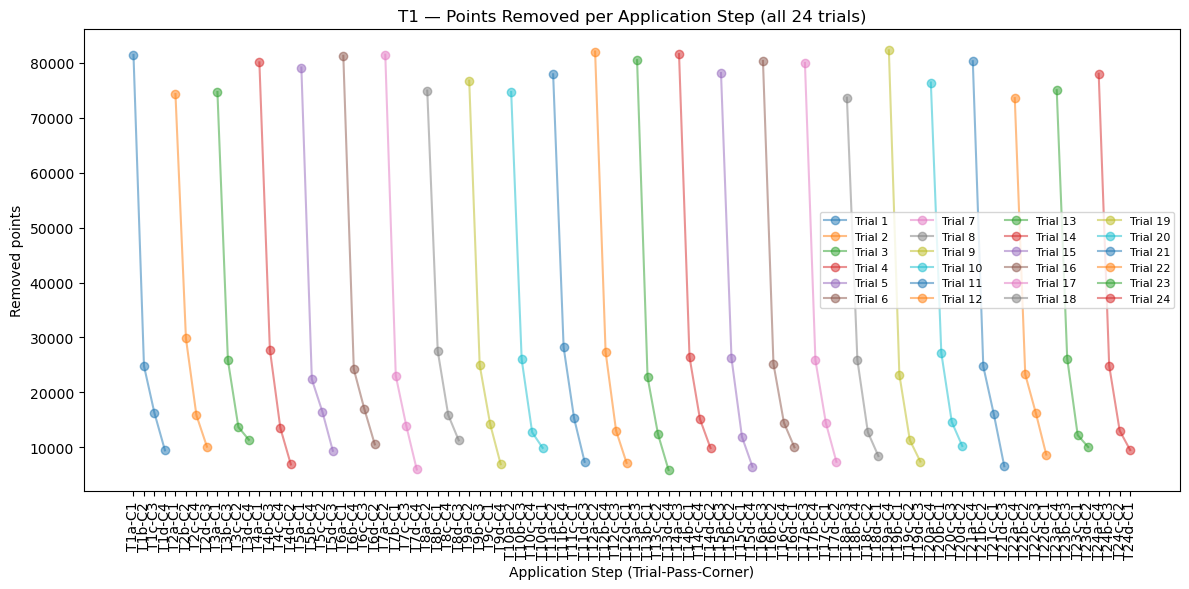

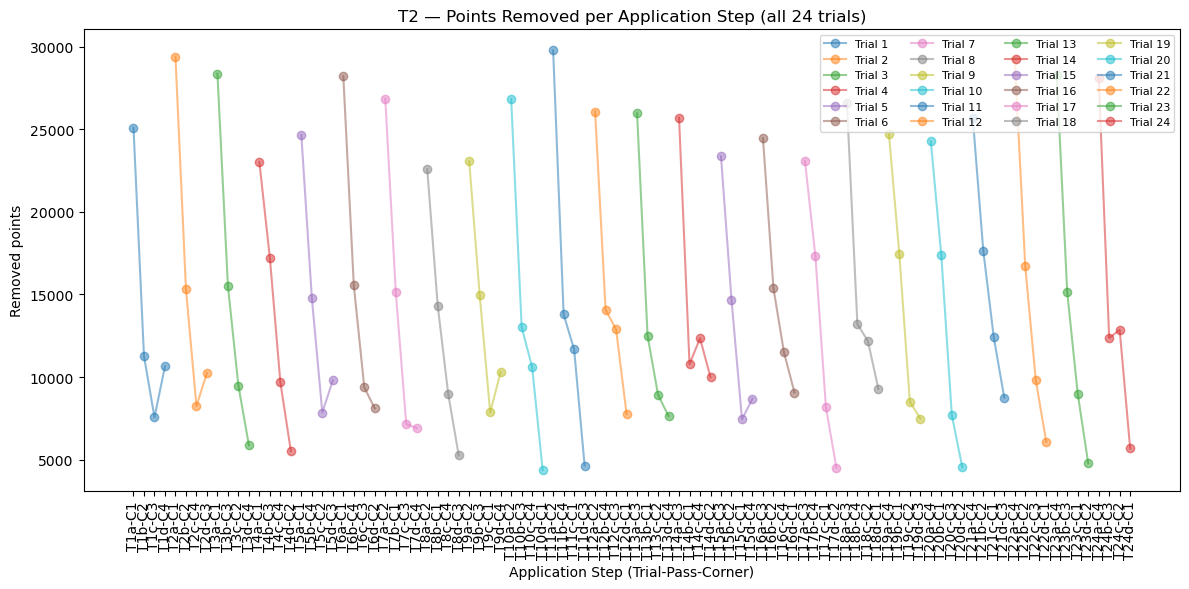

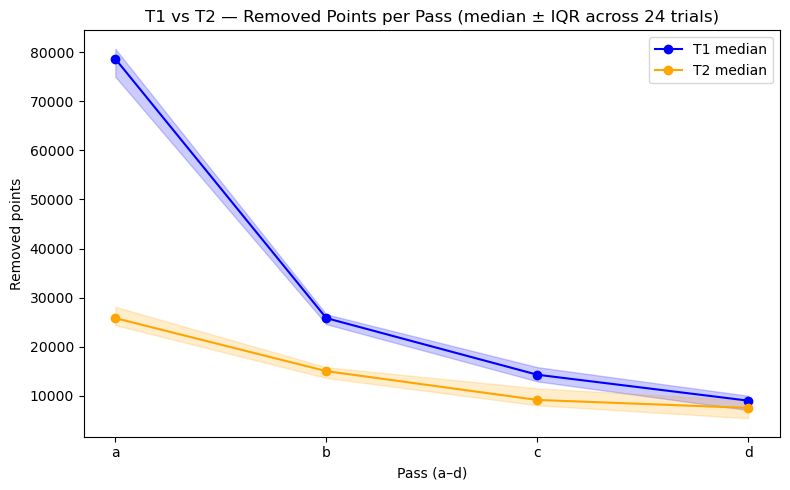

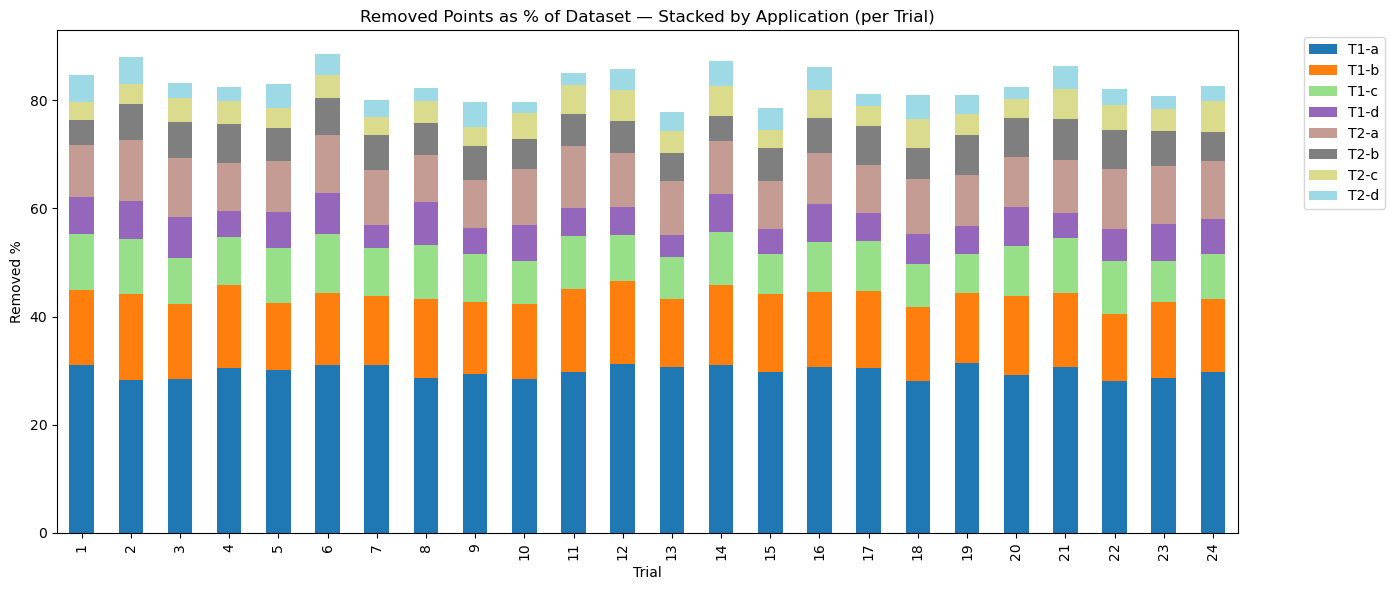

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the long-form dataset exported from the script
df = pd.read_excel("/Users/dnatekar82/Desktop/venv/prof_tables_T1_T2.xlsx", sheet_name="AllSteps_LongForm")

# ---------------- Graph 1: Each Trial curve (T1 only, points removed per application step) ----------------
plt.figure(figsize=(12,6))
for t in df[df["Stage"]=="T1"]["Trial"].unique():
    subset = df[(df["Trial"]==t) & (df["Stage"]=="T1")]
    xlabels = [f"T{t}{row['AppLetter']}-C{row['Corner']}" for _, row in subset.iterrows()]
    plt.plot(xlabels, subset["Removed"], marker="o", alpha=0.5, label=f"Trial {t}")

plt.title("T1 — Points Removed per Application Step (all 24 trials)")
plt.ylabel("Removed points")
plt.xlabel("Application Step (Trial-Pass-Corner)")
plt.xticks(rotation=90)
plt.legend(ncol=4, fontsize=8)
plt.tight_layout()
plt.show()

# ---------------- Graph 2: Each Trial curve (T2 only) ----------------
plt.figure(figsize=(12,6))
for t in df[df["Stage"]=="T2"]["Trial"].unique():
    subset = df[(df["Trial"]==t) & (df["Stage"]=="T2")]
    xlabels = [f"T{t}{row['AppLetter']}-C{row['Corner']}" for _, row in subset.iterrows()]
    plt.plot(xlabels, subset["Removed"], marker="o", alpha=0.5, label=f"Trial {t}")

plt.title("T2 — Points Removed per Application Step (all 24 trials)")
plt.ylabel("Removed points")
plt.xlabel("Application Step (Trial-Pass-Corner)")
plt.xticks(rotation=90)
plt.legend(ncol=4, fontsize=8)
plt.tight_layout()
plt.show()

# ---------------- Graph 3: Aggregate across trials (median ± IQR) ----------------
plt.figure(figsize=(8,5))
agg = (df.groupby(["Stage","Step"])
         .agg(Removed_median=("Removed","median"),
              Removed_q25=("Removed",lambda x: x.quantile(0.25)),
              Removed_q75=("Removed",lambda x: x.quantile(0.75)))
         .reset_index())

for stage, color in [("T1","blue"), ("T2","orange")]:
    sub = agg[agg["Stage"]==stage]
    steps = ["a","b","c","d"]
    plt.plot(steps, sub["Removed_median"], marker="o", label=f"{stage} median", color=color)
    plt.fill_between(steps, sub["Removed_q25"], sub["Removed_q75"], alpha=0.2, color=color)

plt.title("T1 vs T2 — Removed Points per Pass (median ± IQR across 24 trials)")
plt.ylabel("Removed points")
plt.xlabel("Pass (a–d)")
plt.legend()
plt.tight_layout()
plt.show()

# ---------------- Graph 4: Stacked column per Trial (Removed as % of total) ----------------
pivot = df.pivot_table(index="Trial", columns="Application", values="Removed_%", aggfunc="sum")
pivot.plot(kind="bar", stacked=True, figsize=(14,6), colormap="tab20")
plt.title("Removed Points as % of Dataset — Stacked by Application (per Trial)")
plt.ylabel("Removed %")
plt.xlabel("Trial")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()
